<a href="https://colab.research.google.com/github/onebottlekick/bhban_ai_pytorch/blob/main/CNN/style_transfer/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib

import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image

In [2]:
os.makedirs('samples', exist_ok=True)

def download(img, root='https://github.com/onebottlekick/bhban_ai_pytorch/raw/main/CNN/style_transfer/samples/'):
    file_path = os.path.join('samples', img)
    urllib.request.urlretrieve(root+img, file_path)

content = 'content.jpg'
content_path = os.path.join('samples', content)

style = 'style.jpg'
style_path = os.path.join('samples', style)

download(content)
download(style)

In [3]:
def load_img(img, transform, device):
    img = Image.open(img).convert('RGB')
    img = transform(img)
    
    return img.to(device)


def gram_matrix(x):
    N, C, H, W = x.shape
    features = x.view(N*C, H*W)
    gram = torch.mm(features, features.t())
    return gram/(2*N*C*H*W)


def plot(img, title=None):
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(img)
    plt.show()

In [4]:
class Normalization(nn.Module):
    def __init__(self, mean, std, device):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean)/self.std


class StyleTransfer:
    def __init__(self, device, layers={1:'s', 2:'s', 3:'s', 4:'sc', 5:'s'}):
        self.layers = layers
        self.normalization = Normalization(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], device='cuda' if torch.cuda.is_available else 'cpu')
        self.model = self._get_model().to(device)
    
    def _get_model(self):
        vgg = nn.ModuleList(models.vgg19(pretrained=True).features)
        
        for param in vgg.parameters():
            param.requires_grad_(False)
        
        conv_idx = []   
        for idx, layer in enumerate(vgg):
            if isinstance(layer, nn.MaxPool2d):
                layer = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding)
            
            elif isinstance(layer, nn.Conv2d):
                conv_idx.append(idx)

            elif isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=False)
        
        model = nn.Sequential(self.normalization, *vgg[:conv_idx[len(self.layers)]])
        self.conv_idx = conv_idx
        
        return model

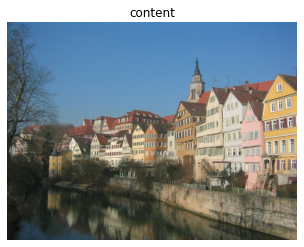

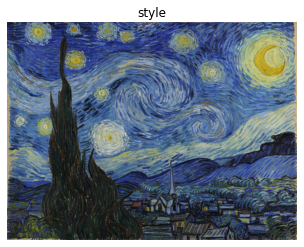


Epoch [01/1001] content_loss=266.014160, style_loss=0.367088
total_loss=367354.500000


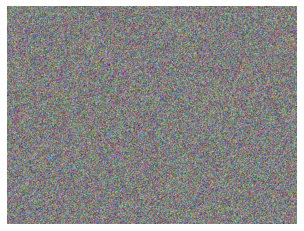



Epoch [51/1001] content_loss=73.594223, style_loss=0.000655
total_loss=728.969727


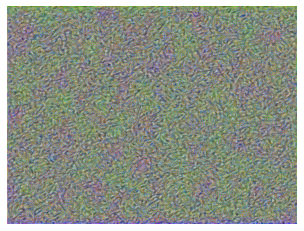



Epoch [101/1001] content_loss=71.407158, style_loss=0.000225
total_loss=296.215088


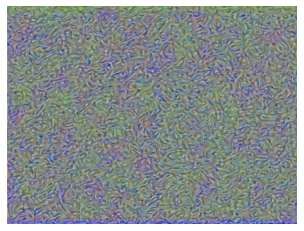



Epoch [151/1001] content_loss=66.284203, style_loss=0.000114
total_loss=179.925598


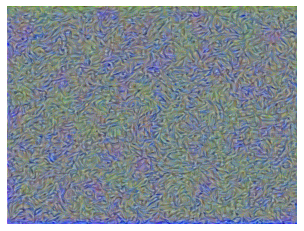



Epoch [201/1001] content_loss=61.363106, style_loss=0.000063
total_loss=124.155991


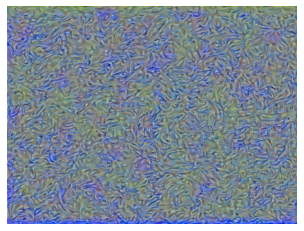



Epoch [251/1001] content_loss=56.895638, style_loss=0.000043
total_loss=100.294968


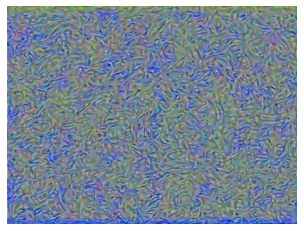



Epoch [301/1001] content_loss=53.070469, style_loss=0.000035
total_loss=87.995811


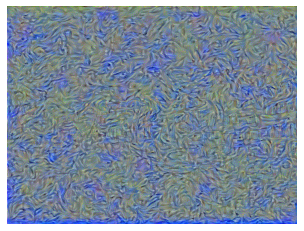



Epoch [351/1001] content_loss=49.920490, style_loss=0.000030
total_loss=79.761795


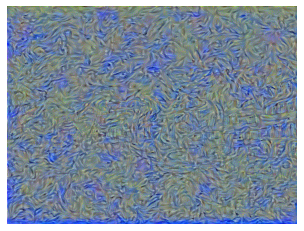



Epoch [401/1001] content_loss=47.309879, style_loss=0.000026
total_loss=73.554581


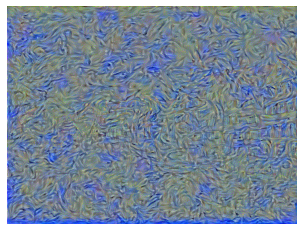



Epoch [451/1001] content_loss=45.097504, style_loss=0.000024
total_loss=68.598106


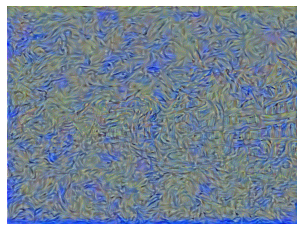



Epoch [501/1001] content_loss=43.197735, style_loss=0.000021
total_loss=64.511688


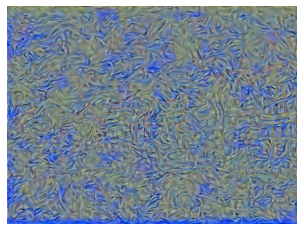



Epoch [551/1001] content_loss=41.538849, style_loss=0.000020
total_loss=61.058590


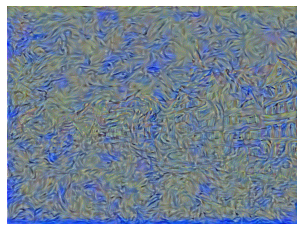



Epoch [601/1001] content_loss=40.092449, style_loss=0.000018
total_loss=58.102234


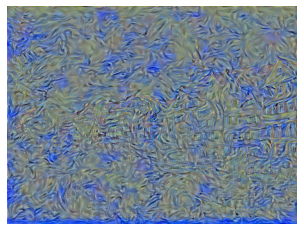



Epoch [651/1001] content_loss=38.805313, style_loss=0.000017
total_loss=55.523872


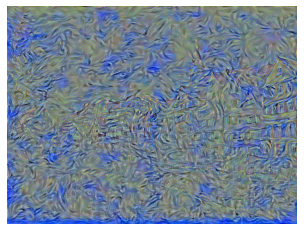



Epoch [701/1001] content_loss=37.645504, style_loss=0.000016
total_loss=53.242775


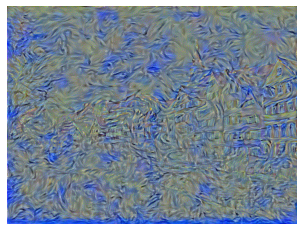



Epoch [751/1001] content_loss=36.589691, style_loss=0.000015
total_loss=51.205132


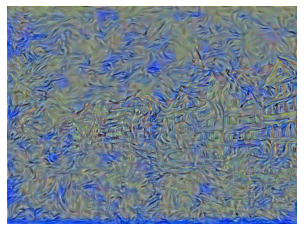



Epoch [801/1001] content_loss=35.629097, style_loss=0.000014
total_loss=49.373394


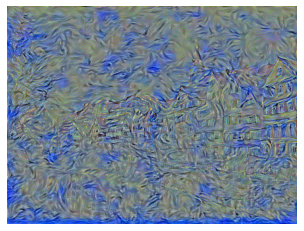



Epoch [851/1001] content_loss=34.751381, style_loss=0.000013
total_loss=47.715965


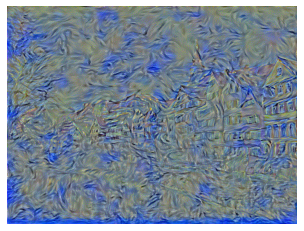



Epoch [901/1001] content_loss=33.945248, style_loss=0.000012
total_loss=46.208920


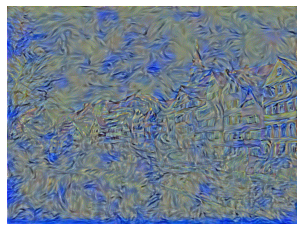



Epoch [951/1001] content_loss=33.205894, style_loss=0.000012
total_loss=44.829815


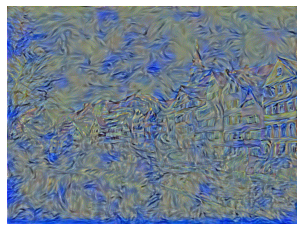



Epoch [1001/1001] content_loss=32.523327, style_loss=0.000011
total_loss=43.560673


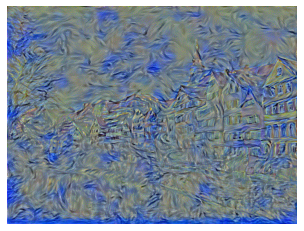

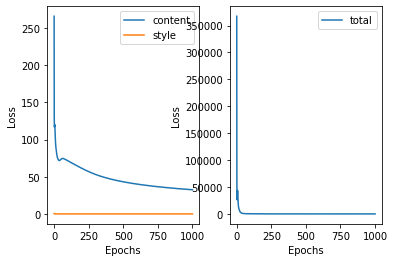

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

style_transfer = StyleTransfer(DEVICE)
model = style_transfer.model
layers = style_transfer.layers
conv_idx = style_transfer.conv_idx

resize = (480, 640)
transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor()
])

content = load_img(content_path, transform, DEVICE).unsqueeze(0)
style = load_img(style_path, transform, DEVICE).unsqueeze(0)

plot(content.squeeze().permute(1, 2, 0).cpu().numpy(), title='content')
print()
plot(style.squeeze().permute(1, 2, 0).cpu().numpy(), title='style')

noise = torch.rand(content.shape, device=DEVICE, requires_grad=True)

NUM_EPOCHS = 1001
learning_rate = 0.1
alpha = 1e+0
beta = 1e+6

# optimizer = torch.optim.Adam([noise])
optimizer = torch.optim.Adam([noise], lr=learning_rate)
criterion = nn.MSELoss()

content_losses = []
style_losses = []
total_losses = []
for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    style_loss = 0
    content_loss = 0
    
    noise.data.clip_(0, 1)
    for idx in layers.keys():
        if 'c' in layers[idx]:
            target_content = model[:conv_idx[idx]+2](content).detach()
            noise_content = model[:conv_idx[idx]+2](noise)
            content_loss += criterion(noise_content, target_content)
        if 's' in layers[idx]:
            target_style = gram_matrix(model[:conv_idx[idx]+2](style)).detach()
            noise_style = gram_matrix(model[:conv_idx[idx]+2](noise))
            style_loss += criterion(noise_style, target_style)
            
    content_losses.append(content_loss.item())
    style_losses.append(style_loss.item())
    
    total_loss = alpha*content_loss + beta*style_loss
    total_losses.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print('='*70)
        print()
        print(f'Epoch [{epoch+1:02}/{NUM_EPOCHS}] content_loss={content_loss:6f}, style_loss={style_loss:.6f}')
        print(f'total_loss={total_loss:.6f}')
        plot(noise.data.clip_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))
        print()
        print('='*70)


plt.title('Loss')
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(content_losses, label='content')
plt.plot(style_losses, label='style')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(total_losses, label='total')
plt.legend()

plt.show()